In [1]:
%matplotlib inline

from IPython.display import display
from IPython.display import Image

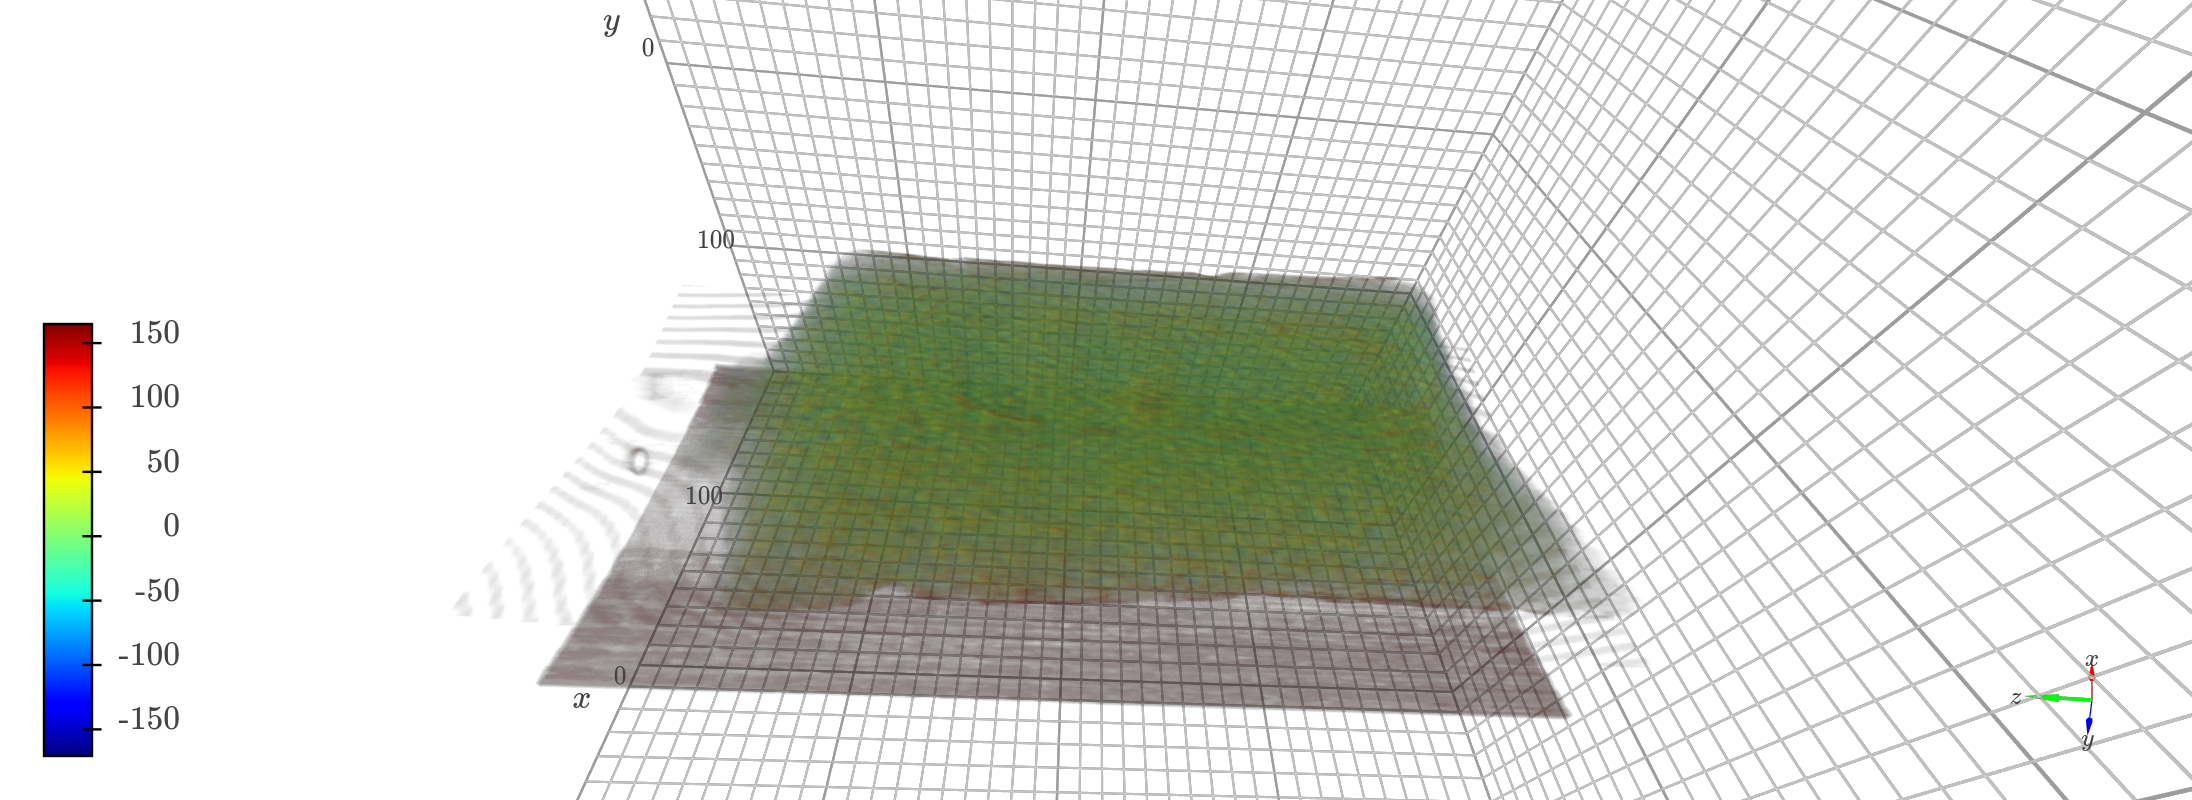

In [2]:
Image(filename="plots/saline_bag-volume_rendering.png", width=800)

## Import Python packages

In [3]:
from os import path
from os import walk
import numpy as np
import math
import base64
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tifffile import imsave # Save TIFF images in Float32
import SimpleITK as sitk
from sitk2vtk import sitk2vtk
from utils import * # Code shared across more than one notebook
import k3d
from stl import mesh

from sklearn import cluster
from sklearn.preprocessing import StandardScaler

import spekpy as sp # Generate a beam spectrum
from scipy import signal # Resampling the beam spectrum
import cma # Optimisation (minimisation of an objective function)
from sklearn.metrics import mean_squared_error # For the objective function
from skimage.metrics import structural_similarity as ssim # Quantifying the similarities between the simulated image and the ground truth
from sklearn.metrics import mean_absolute_percentage_error as mape # Quantifying the difference between the simulated image and the ground truth

import cv2 as cv

import gvxrPython3 as gvxr # Simulate X-ray images
from utils import *

Some global variables

In [4]:
number_of_thresholds = 1

data_directory = 'saline_bag/SE000002'
original_output_file = 'saline_bag/SE000002.mha'
small_output_file = 'saline_bag/SE000002-small.mha'
segmentation_file = 'saline_bag/SE000002-seg' + str(number_of_thresholds) + '.mha'
small_segmentation_file = 'saline_bag/SE000002-small-seg' + str(number_of_thresholds) + '.mha'

## Read the CT data

Only load the DICOM files if the MHA file does not exit.

In [5]:
if path.isfile(original_output_file):
    print("Reading file:", original_output_file)
    reader = sitk.ImageFileReader()
    reader.SetFileName(original_output_file)
    itk_image = reader.Execute()
else:
    print("Reading Dicom directory:", data_directory)
    reader = sitk.ImageSeriesReader()
    
    # Find the DICOM files
    dicom_file_names = reader.GetGDCMSeriesFileNames(data_directory)    

    # Read the DICOM files
    print("Reading the DICOM files in", data_directory)
    reader.SetFileNames(dicom_file_names)
    itk_image = reader.Execute()

Reading file: saline_bag/SE000002.mha


Print some details about the data

In [6]:
original_size = itk_image.GetSize()
original_spacing = itk_image.GetSpacing()

print("Image size:", original_size)
print("Pixel spacing:", original_spacing)

Image size: (512, 512, 415)
Pixel spacing: (0.24609375, 0.24609375, 0.6999999999999998)


If needed, save the MHA image file from the DICOM files

In [7]:
if not path.isfile(original_output_file):
    print("Writing image:", original_output_file)
    sitk.WriteImage(itk_image, original_output_file, useCompression=True)

Convert in a numpy array

In [8]:
image_array = sitk.GetArrayFromImage(itk_image) # z, y, x

Resample the data to have less voxels (needed for volume rendering and testing the imaging pipeline)

In [9]:
if path.isfile(small_output_file):
    print("Reading file:", small_output_file)
    reader = sitk.ImageFileReader()
    reader.SetFileName(small_output_file)
    small_image = reader.Execute()
else:
    print("Resampling the image")

    out_spacing = np.copy(original_spacing) * 4

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
    ]

    small_image = sitk.Resample(image1=itk_image,
                          size=out_size,
                          transform=sitk.Transform(),
                          interpolator=sitk.sitkBSpline,
                          outputOrigin=itk_image.GetOrigin(),
                          outputSpacing=out_spacing,
                          outputDirection=itk_image.GetDirection(),
                          defaultPixelValue=itk_image.GetPixelIDValue(),
                          outputPixelType=itk_image.GetPixelID(),
                         )
    
    print("Writing image:", small_output_file)
    sitk.WriteImage(small_image, small_output_file, useCompression=True)


Reading file: saline_bag/SE000002-small.mha


Convert in a numpy array

In [10]:
small_image_array = sitk.GetArrayFromImage(small_image) # z, y, x

Produce an image of volume rendering

In [11]:
plot = k3d.plot()

# loading data to the `density` array
cmap = k3d.colormaps.matplotlib_color_maps.jet

volume_size = np.array(itk_image.GetSize()) * np.array(itk_image.GetSpacing())

volume = k3d.volume(
    small_image_array.astype(np.float32),
    alpha_coef=5,
    shadow='dynamic',
    samples=300,
    shadow_res=128,
    shadow_delay=50,
    color_range=[small_image_array.min() / 6, small_image_array.max() / 6],
    color_map=(np.array(cmap).reshape(-1,4)).astype(np.float32)
)

volume.transform.bounds = [-volume_size[0] / 2, volume_size[0] / 2,
                           -volume_size[1] / 2, volume_size[1] / 2,
                           -volume_size[2] / 2, volume_size[2] / 2]

plot = k3d.plot(camera_auto_fit=True, height=400)

plot += volume
plot.display()

Output()

In [12]:
# plot.fetch_screenshot()

# data = base64.b64decode(plot.screenshot)
# with open('plots/saline_bag-volume_rendering.png','wb') as fp:
#     fp.write(data)

## Segment the CT volume using the Otsu's method

Mathematical morphology is used to "cleaned" the binary data

In [13]:
def segment(itk_image, fname=None):
    if number_of_thresholds == 1:
        # Apply the Otsu's method
        otsu_filter = sitk.OtsuThresholdImageFilter();
        otsu_filter.SetInsideValue(0);
        otsu_filter.SetOutsideValue(1);
        seg = otsu_filter.Execute(itk_image);

        # Print the corresponding threshold
        # print("Threshold:", otsu_filter.GetThreshold());
    else:
        # Apply the Otsu's method
        otsu_filter = sitk.OtsuMultipleThresholdsImageFilter()
        otsu_filter.SetNumberOfThresholds(number_of_thresholds)
        seg = otsu_filter.Execute(itk_image);

        # Print the corresponding threshold
        # print("Thresholds:", otsu_filter.GetThresholds());
    
    vectorRadius=(1, 1, 1)
    kernel=sitk.sitkBall
    seg = sitk.BinaryMorphologicalClosing(seg, vectorRadius, kernel)
    seg = sitk.BinaryMorphologicalOpening(seg, vectorRadius, kernel)

    if fname is not None:
        print("Writing image:", fname)
        sitk.WriteImage(seg, fname, useCompression=True)
    
    return seg, sitk.GetArrayFromImage(seg)

In [14]:
seg, segment_array = segment(itk_image, segmentation_file)

Writing image: saline_bag/SE000002-seg1.mha


## Find the different elements

In [15]:
connected = sitk.ConnectedComponent(seg)

sitk.WriteImage(connected, segmentation_file, useCompression=True)

shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(connected)

print(shape_stats.GetLabels())

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27)


In [16]:
connected_array = sitk.GetArrayFromImage(connected)

In [17]:
sitk.WriteImage(connected, "saline_bag/connected.mha", useCompression=True)    

## Display the different objects

In [18]:
overlay = sitk.LabelOverlay(itk_image, connected)
overlay_array = sitk.GetArrayFromImage(overlay).astype(np.single) # z, y, x

overlay_array -= overlay_array.min()
overlay_array /= overlay_array.max()
overlay_array *= 255

overlay_array = overlay_array.astype(np.uint8)

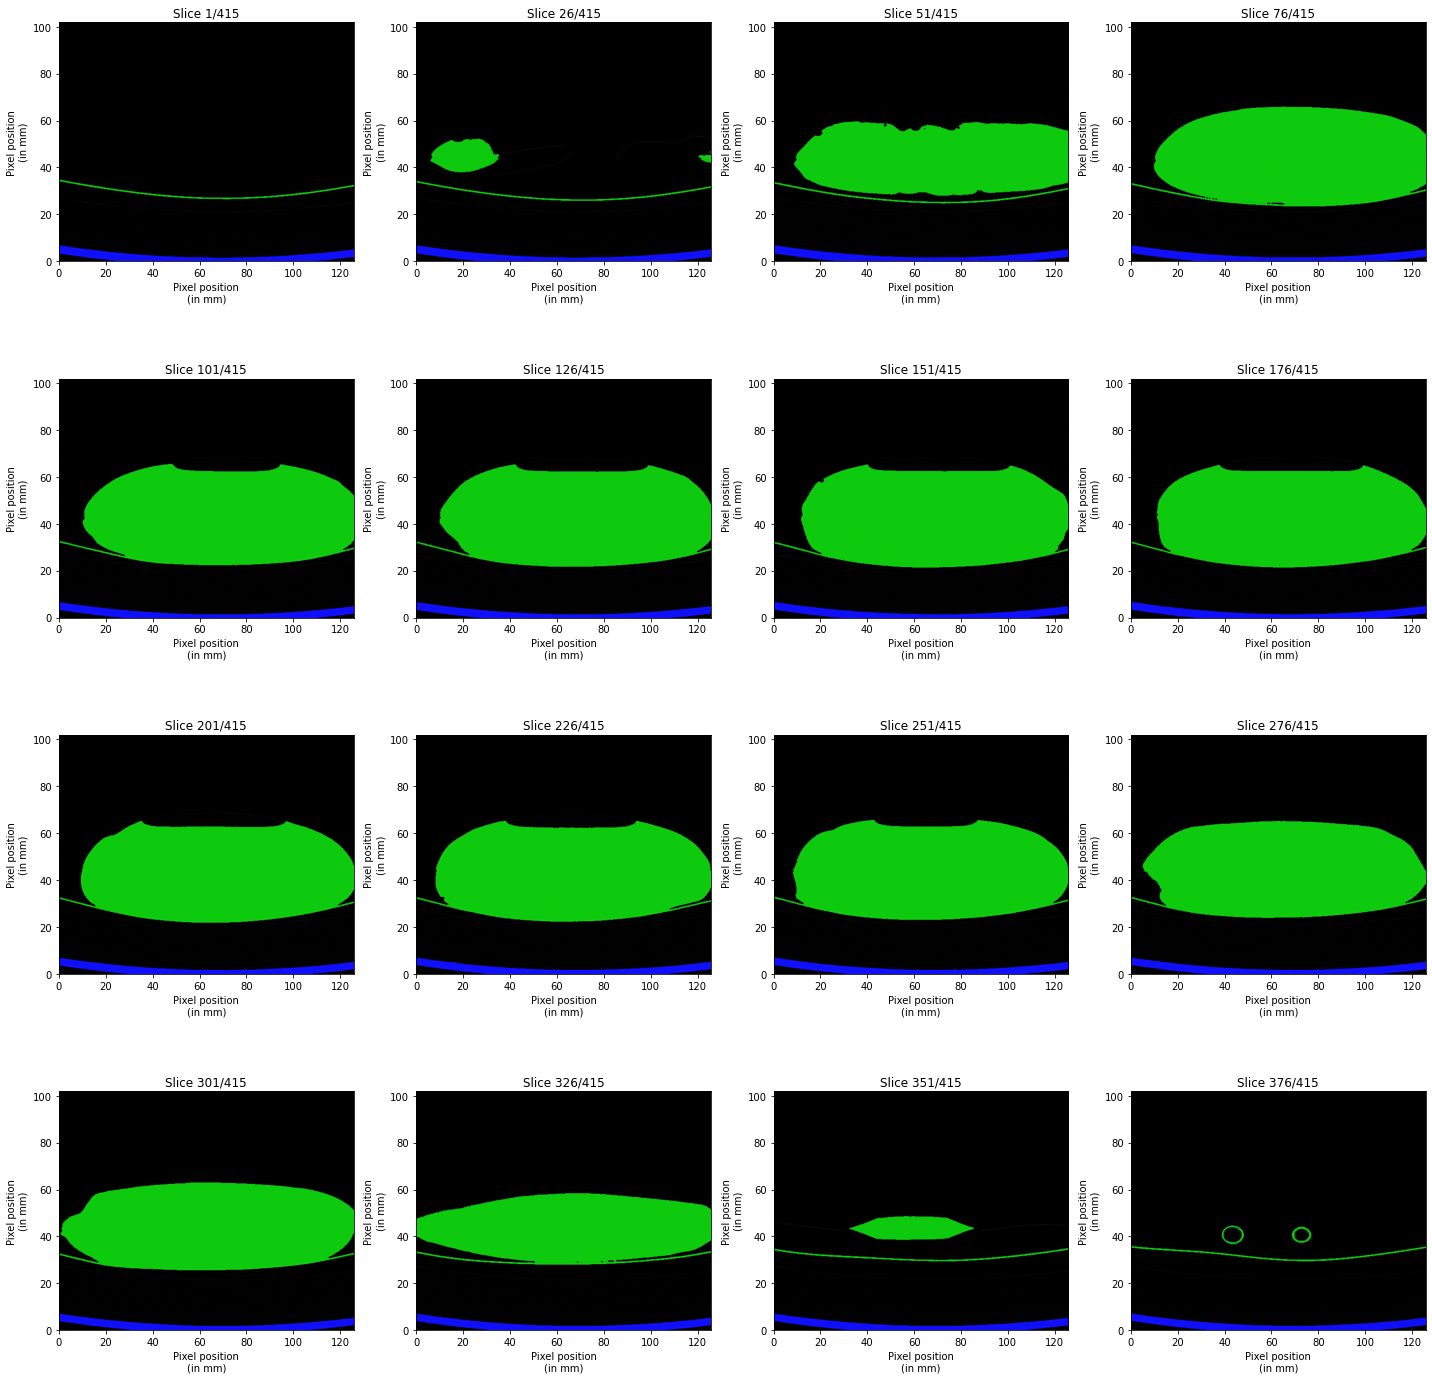

In [19]:
ncols = 4
nrows = 4

step = int(overlay_array.shape[0] / (ncols * nrows))
slices = range(0, int(overlay_array.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(overlay_array.shape[0]))
        ax.set_xlabel("Pixel position\n(in mm)")
        ax.set_ylabel("Pixel position\n(in mm)")
        ax.imshow(overlay_array[slice_id],
                  cmap='gray', 
                  extent=[0,(overlay_array.shape[1]-1)*original_spacing[0],0,(overlay_array.shape[0]-1)*original_spacing[1]])
        
plt.tight_layout()

## Get the average HU value for each structure

In [20]:
HU_mean = []
for i in shape_stats.GetLabels():
    
    # Threshold the phantom
    binary_image = (connected == i)

    binary_image_array = sitk.GetArrayFromImage(binary_image).astype(np.uint8)
    
    test = (binary_image_array == True)
    
    HU_mean.append(image_array[test].mean())
    # print(i, HU_mean[-1], image_array[test].std())

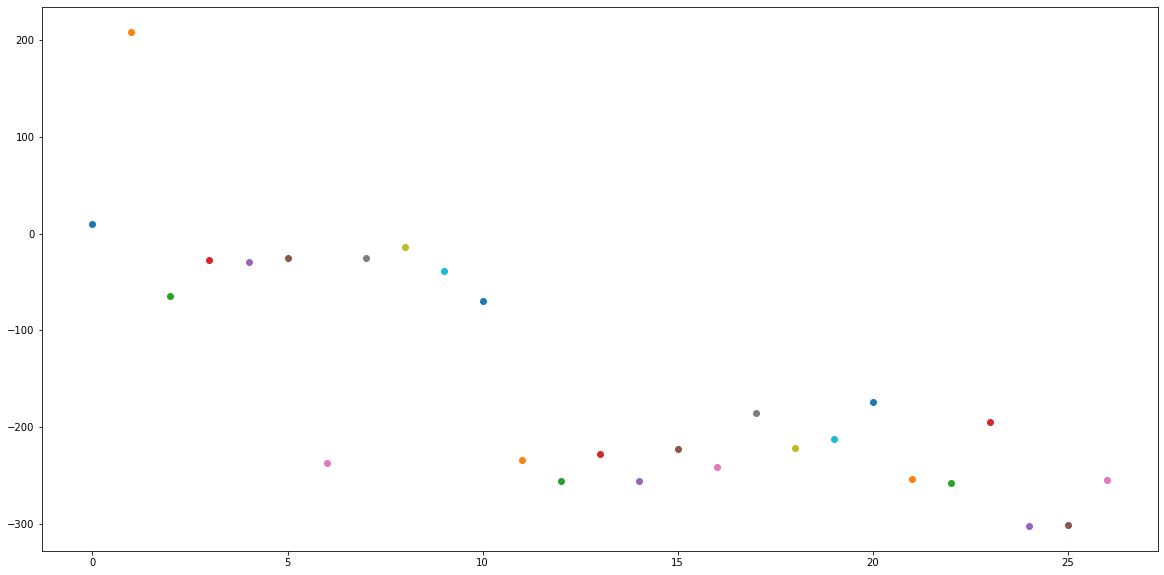

In [21]:
plt.figure(figsize=(20, 10))

for i, HU in enumerate(HU_mean):
    plt.scatter(i, HU)

[ 0 -1  0  0  0  0  1  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1]


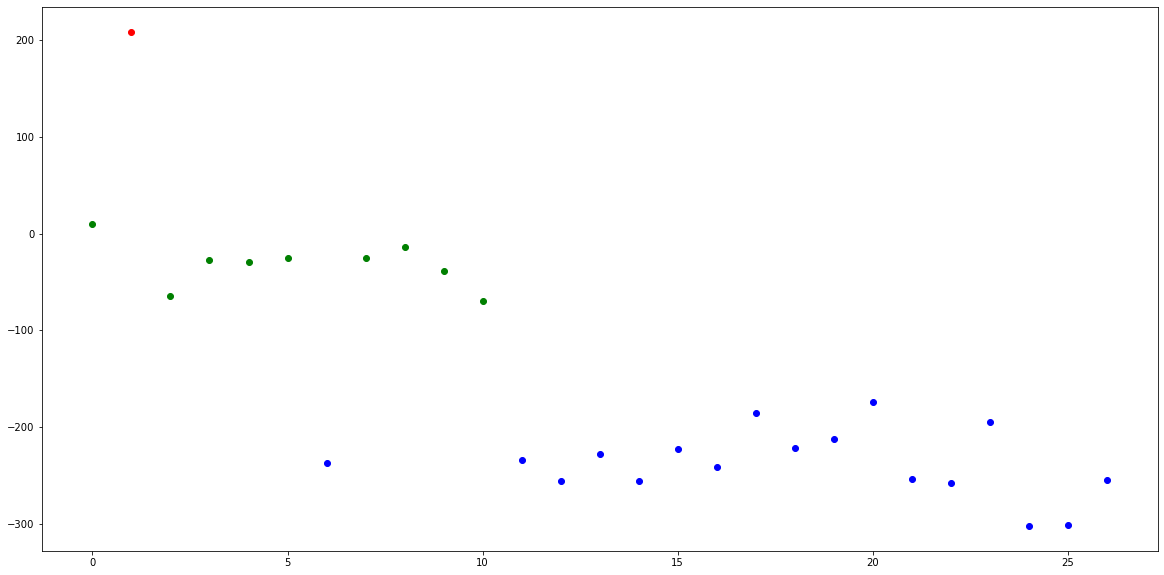

In [22]:
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(np.array(HU_mean).reshape(-1, 1))

dbscan = cluster.DBSCAN()

y_pred = dbscan.fit_predict(X)

print(y_pred)

plt.figure(figsize=(20, 10))

for i, (y, HU) in enumerate(zip(y_pred, HU_mean)):
    if y == -1:
        colour = "red"
    elif y == 0:
        colour = "green"
    elif y == 1:
        colour = "blue"
    else:
        colour = "black"

    plt.scatter(i, HU, color=colour)

## Create STL files from the segmentation

The clustering is used to reduce the number of objects

In [23]:
HU_mean_new = []

for i, cluster_id in enumerate(np.unique(y_pred)):

    # Threshold the phantom
    binary_image = None

    # Combine similar segmentations into a single one
    for y, HU in zip(y_pred, HU_mean):

        if y == cluster_id:
            if binary_image is None:
                binary_image = (connected == i + 1)
            else:
                binary_image += (connected == i + 1)

    # Smooth the binary segmentation
    smoothed_binary_image = sitk.AntiAliasBinary(binary_image)
    
    # Retrieve the average HU value of the segmentation
    binary_image_array = sitk.GetArrayFromImage(smoothed_binary_image)
    selection = binary_image_array > 0
    HU_mean_new.append(image_array[selection].mean())
    
    # Write the sementation mask
    sitk.WriteImage(smoothed_binary_image, "saline_bag/saline_bag-label-" + str(i) + ".mha", useCompression=True)    
    
    
    padded = sitk.ConstantPad(smoothed_binary_image, padLowerBound = [1,1,1], padUpperBound = [1,1,1], constant = -1024)
    
    # Create a VTK image
    vtkimg = sitk2vtk(padded, centre=True)

    # Extract the polygon mesh
    vtkmesh = extractSurface(vtkimg, 0)

    # Write the corresponding mesh as a STL file
    writeSTL(vtkmesh, "saline_bag/saline_bag-seg-" + str(i) + ".stl")
    
    print(i, HU_mean_new[-1])

0 10.158327931427932
1 208.47422806050716
2 -64.02816901408451


## Visualisation of the polygon meshes

In [24]:
plot = k3d.plot(camera_auto_fit=True, height=400)
plot.background_color = 0xffffff

# loading data to the `density` array
cmap = k3d.colormaps.matplotlib_color_maps.jet

volume_size = np.array(itk_image.GetSize()) * np.array(itk_image.GetSpacing())

for i in range(len(HU_mean_new)):
    
    mesh_from_stl_file = mesh.Mesh.from_file("saline_bag/saline_bag-seg-" + str(i) + ".stl")

    colour = random.randint(0,256*256*256 - 1)
    
#     if len(HU_mean_new) == 3:
#         if i == 0:
#             colour = 256 * 256 * 256 + 256 * 0 + 0 - 1
#         elif i == 1:
#             colour = 256 * 256 * 0 + 256 * 256 + 0 - 1
#         else:
#             colour = 256 * 256 * 0 + 256 * 0 + 256 - 1

    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=colour, 
                          wireframe=False, 
                          flat_shading=False,
                          name="fname",
                          opacity = 1)
    
    plot += geometry
    
plot.display()

Output()

In [25]:
# plot.fetch_screenshot()

# data = base64.b64decode(plot.screenshot)
# with open('plots/saline_bag-meshes.png','wb') as fp:
#     fp.write(data)

## Load the 2D projection from the DICOM file

In [26]:
reader = sitk.ImageFileReader()
reader.SetImageIO("GDCMImageIO")
reader.SetFileName("saline_bag/SE000001/CT000001")
reader.LoadPrivateTagsOn()
reader.ReadImageInformation()    
volume = reader.Execute()
raw_real_image = sitk.GetArrayFromImage(volume)[0]

Writing image: CT000001-seg.tif
ref_top_left_corner [45 84]
ref_bottom_left_corner [ 53 311]


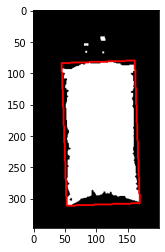

In [27]:
roi_raw_real_image = raw_real_image[:347,150:350]

imsave("saline_bag/CT000001.tif", np.array(255 * (roi_raw_real_image - roi_raw_real_image.min() / (roi_raw_real_image.max() - roi_raw_real_image.min())).astype(np.uint8)))
imsave("saline_bag/CT000001.tif", roi_raw_real_image.astype(np.single))


proj_img, proj_array = segment(volume[150:350,:347], "CT000001-seg.tif")

contours, hierarchy = cv.findContours(proj_array[0], 1, 2)

largest_contour = -1
largest_contour_perimeter = 0

for i, cnt in enumerate(contours):
    
    perimeter = cv.arcLength(cnt, True)
    
    if largest_contour_perimeter < perimeter:
        largest_contour_perimeter = perimeter
        largest_contour = i

img = 255 * proj_array[0]

img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
rect = cv.minAreaRect(contours[largest_contour])
box = cv.boxPoints(rect)
ref_box = np.int0(box)
cv.drawContours(img, [ref_box], 0, (255,0,0), 2)

plt.imshow(img)

ref_box_index = ref_box[:,0].argsort()

if ref_box[ref_box_index[0]][1] < ref_box[ref_box_index[1]][1]:
    ref_top_left_corner = ref_box[ref_box_index[0]]
    ref_bottom_left_corner = ref_box[ref_box_index[1]]
else:
    ref_top_left_corner = ref_box[ref_box_index[1]]
    ref_bottom_left_corner = ref_box[ref_box_index[0]]

print("ref_top_left_corner", ref_top_left_corner)
print("ref_bottom_left_corner", ref_bottom_left_corner)

## Extract the image size and pixel spacing from the DICOM file

It will be useful to set the X-ray detector parameters for the simulation, and to display the images in millimetres.

In [28]:
spacing = volume.GetSpacing()[0:2]
size = volume.GetSize()[0:2]

## Extract the kVp from the DICOM file

It will be useful to set the X-ray beam spectrum for the simulation.

In [29]:
kVp = float(volume.GetMetaData("0018|0060"))
print("Peak kilo voltage output of the x-ray generator used: ", kVp)

Peak kilo voltage output of the x-ray generator used:  120.0


## Display the experimental 2D projection from the DICOM file

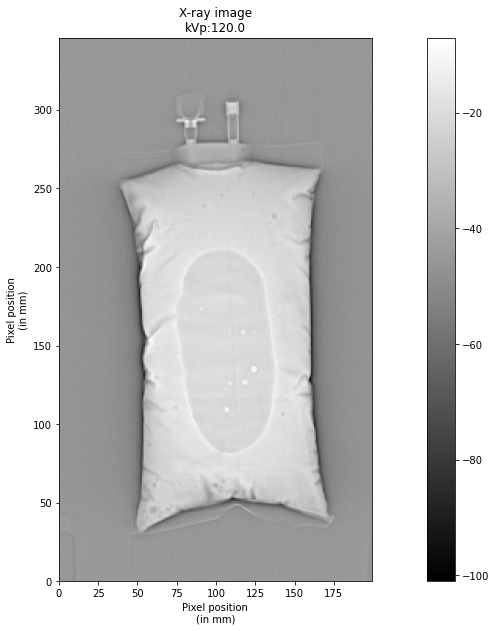

In [30]:
plt.figure(figsize= (20,10))

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title("X-ray image\nkVp:" + str(kVp))
plt.imshow(roi_raw_real_image, cmap="gray", 
           vmin=-101, vmax = -7,
           extent=[0,(roi_raw_real_image.shape[1]-1)*spacing[0],0,(roi_raw_real_image.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='vertical')

plt.savefig('plots/saline_bag_experimental_image.pdf')
plt.savefig('plots/saline_bag_experimental_image.png')

## Initialise the X-ray segmentation

In [31]:
# Create an OpenGL context
window_size =  [800, 450]
print("Create an OpenGL context:",
    str(window_size[0]) + "x" + str(window_size[1])
);
gvxr.createOpenGLContext();
gvxr.setWindowSize(
    window_size[0],
    window_size[1]
);


Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## Set the experimental parameters (e.g. source and detector positions, etc.)

We use known parameters as much as possible, for example we know the size and composition of the sample. Some parameters are extracted from the DICOM file, such as detector size, pixel resolution, and voltage of the X-ray tube.

In [32]:
# meta_data_keys = volume.GetMetaDataKeys()

# print("DICOM fields:")
# for key in meta_data_keys:
#     print(key, volume.GetMetaData(key))

In [33]:
distance_source_to_detector = float(volume.GetMetaData("0018|1110"))
distance_source_to_patient = float(volume.GetMetaData("0018|1111"))
distance_detector_to_patient = distance_source_to_detector - distance_source_to_patient

print("Distance Source to Detector:", distance_source_to_detector)
print("Distance Source to Patient:", distance_source_to_patient)
print("Distance Detector to Patient:", distance_detector_to_patient)

Distance Source to Detector: 1085.6
Distance Source to Patient: 595.0
Distance Detector to Patient: 490.5999999999999


In [34]:
source_position = [0.0, -distance_source_to_patient, 0.0, "mm"]
detector_position = [0.0, distance_detector_to_patient, 0.0, "mm"]
detector_up = [0, 0, -1]

## Set the source position

In [35]:
# Set up the beam
print("Set up the beam")
print("\tSource position:", source_position)
gvxr.setSourcePosition(
    source_position[0],
    source_position[1],
    source_position[2],
    source_position[3]
);

gvxr.usePointSource();

Set up the beam
	Source position: [0.0, -595.0, 0.0, 'mm']


## Get the spectrum from the DICOM file

In [36]:
spectrum = {};
filter_material = "Al"      # See email Mon 05/07/2021 15:29
filter_thickness_in_mm = 3  # See email Mon 05/07/2021 15:29

s = sp.Spek(kvp=kVp)
s.filter(filter_material, filter_thickness_in_mm) # Filter by 3 mm of Al
unit = "keV"
k, f = s.get_spectrum(edges=True) # Get the spectrum

min_energy = sys.float_info.max
max_energy = -sys.float_info.max

for energy, count in zip(k, f):
    count = round(count)

    if count > 0:

        max_energy = max(max_energy, energy)
        min_energy = min(min_energy, energy)

        if energy in spectrum.keys():
            spectrum[energy] += count
        else:
            spectrum[energy] = count

In [37]:
# get the integral nb of photons
nbphotons=0.
energy1 = -1.
energy2 = -1.

for energy in spectrum.keys():
    
    if energy1<0:
        energy1 = float(energy)
    elif energy2<0:
        energy2 = float(energy)
    nbphotons += float(spectrum[energy])
sampling = (energy2-energy1)

# get spectrum
data = []
for energy in spectrum.keys():
    source = [float(energy),float(spectrum[energy])/(nbphotons*sampling)]
    data.append(source)

data_array = np.array(data)

energies, counts = data_array.T


In [38]:
number_of_energy_bins = 30
count_set = signal.resample(counts, number_of_energy_bins)
energy_set = np.linspace(energies.min(), energies.max(), number_of_energy_bins, endpoint=True)

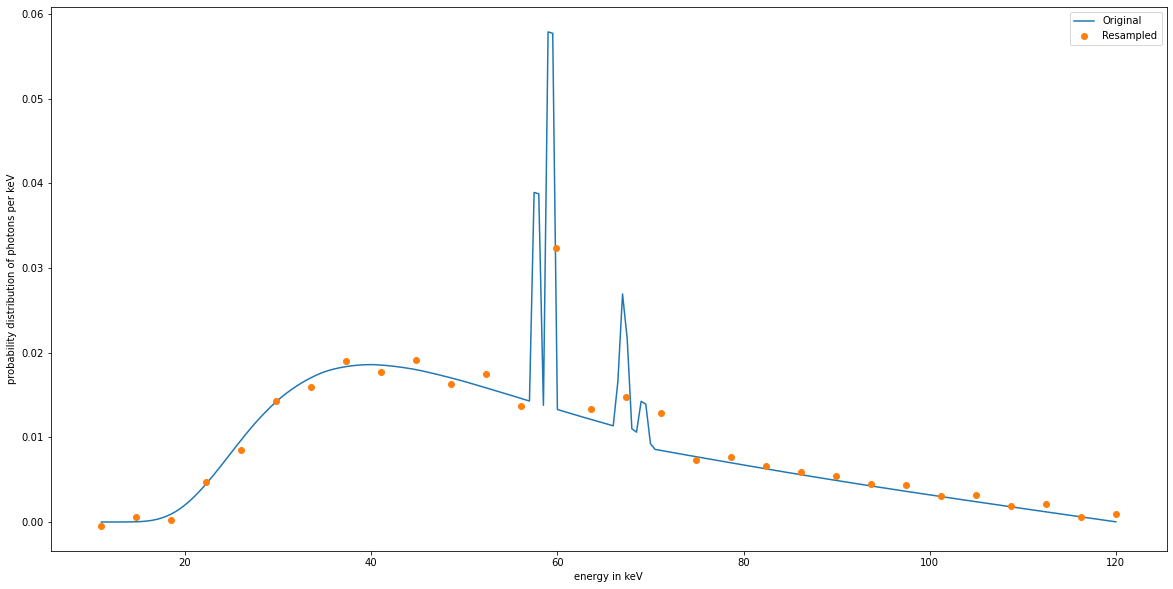

In [39]:
plt.figure(figsize= (20,10))
plt.plot(energies, counts, label="Original")
plt.plot(energy_set, count_set, "o", label="Resampled")
plt.xlabel('energy in keV')
plt.ylabel('probability distribution of photons per keV')
plt.legend()
plt.savefig("plots/saline_bag_spectrum.png")
plt.savefig("plots/saline_bag_spectrum.pdf")

In [40]:
gvxr.resetBeamSpectrum() # To be on the safe side when debugging
for energy, count in zip(energy_set, count_set):
    gvxr.addEnergyBinToSpectrum(energy, unit, count);

## Set the X-ray detector

In [41]:
# Set up the detector
print("Set up the detector");
print("\tDetector position:", detector_position)
gvxr.setDetectorPosition(
    detector_position[0],
    detector_position[1],
    detector_position[2],
    detector_position[3]
);

print("\tDetector up vector:", detector_up)
gvxr.setDetectorUpVector(
    detector_up[0],
    detector_up[1],
    detector_up[2]
);

Set up the detector
	Detector position: [0.0, 490.5999999999999, 0.0, 'mm']
	Detector up vector: [0, 0, -1]


In [42]:
print("\tDetector number of pixels:", size)
gvxr.setDetectorNumberOfPixels(
    size[0],
    size[1]
);

tan_alpha = 1. / distance_source_to_patient
opp = tan_alpha * (distance_source_to_patient + distance_source_to_detector)

# print("\tPixel spacing:", spacing)
print("\tPixel spacing:", (opp, opp))

# distance_source_to_detector = float(volume.GetMetaData("0018|1110"))
# distance_source_to_patient

gvxr.setDetectorPixelSize(
    spacing[0] * 1.860986547,
    spacing[1] * 1.860986547,
    "mm"
);

	Detector number of pixels: (512, 512)
	Pixel spacing: (2.8245378151260505, 2.8245378151260505)
INIT RENDER


In [43]:
gvxr.clearDetectorEnergyResponse() # To be on the safe side
gvxr.loadDetectorEnergyResponse("Gate_data/responseDetector.txt",
                                "MeV")

## Load the meshes

In [44]:
gvxr.removePolygonMeshesFromXRayRenderer()
gvxr.removePolygonMeshesFromSceneGraph()

for i, HU in enumerate(HU_mean_new):
    
    label = "mesh_" + str(i)
    gvxr.loadMeshFile(
        label,
        "saline_bag/saline_bag-seg-" + str(i) + ".stl",
        "mm",
        False
    )
    
    gvxr.setHounsfieldValue(label, HU)
    
    if HU < 100:
        gvxr.addPolygonMeshAsInnerSurface(label)

file_name:	saline_bag/saline_bag-seg-0.stl	nb_faces:	2022800	nb_vertices:	6068400	bounding_box (in cm):	(-6.28779, -1.8457, -14.4903)	(6.28779, 3.64219, 14.4903)
file_name:	saline_bag/saline_bag-seg-1.stl	nb_faces:	1004624	nb_vertices:	3013872	bounding_box (in cm):	(-6.28779, 5.41406, -14.4903)	(6.28779, 6.28779, 14.4903)
file_name:	saline_bag/saline_bag-seg-2.stl	nb_faces:	236	nb_vertices:	708	bounding_box (in cm):	(0.885938, -2.04258, -6.545)	(1.05738, -1.9445, -6.33562)


## Optimise the pixel size, and the position and orientation of the bag

In [45]:
normalised_real_image = standardisation(roi_raw_real_image)

In [46]:
gvxr.displayScene()

gvxr.useNegative()
gvxr.useLighing()
gvxr.useWireframe()
gvxr.setSceneRotationMatrix([ 0.446882426738739,    0.003840845776721835, -0.8945800065994263,   0.0,
                             -0.8941434621810913,   0.03349802643060684,  -0.44652312994003296,  0.0,
                              0.028250280767679214, 0.9994258284568787,    0.018405459821224213, 0.0, 
                              0.0,                  0.0,                   0.0,                  1.0])
gvxr.setZoom(1299.6787109375)

0 0 500 500
0 0 800 450


In [47]:
def transformScene(x, z, theta):
    # Save the transformation matrix
    matrix_bak = gvxr.getSceneTransformationMatrix()
    
    # Rotate, then translate
    gvxr.translateScene(x,
                    0,
                    z,
                    "mm");

    gvxr.rotateScene(theta, 0, 1, 0)

    return matrix_bak

In [48]:
def computeXRayImage(parameters, restoreTransformation=True):
    
    # Retrieve the parameters
    x, z, theta, pixel_size = parameters
    
    # Transform the 3D scene
    matrix_bak = transformScene(x, z, theta)
    
    # Change the pixel size
    gvxr.setDetectorPixelSize(
        pixel_size,
        pixel_size,
        "mm"
    )    
    
    # Compute an X-ray image
    x_ray_image = np.flip(gvxr.computeXRayImage(), 1)
    
    # Restore the transformation matrix
    if restoreTransformation:
        gvxr.setSceneTransformationMatrix(matrix_bak)

    # Compute the negative image as it is the case for the real image
    x_ray_image *= -1.

    return x_ray_image

In [49]:
def zncc(i1, i2):
    return (np.mean(np.multiply(i1, i2))) / 2.0;


ref_sobel = standardisation(sitk.GetArrayFromImage(sitk.SobelEdgeDetection(sitk.GetImageFromArray(roi_raw_real_image.astype(np.single)))))

def objectiveFunction(parameters):
    
    global normalised_real_image
    global best_fitness
    global best_fitness_id
    global fitness_function_call_id
    global ref_box
    global ref_box_index

    simulated_image = computeXRayImage(parameters)[:347,150:350]

    # test_sobel = standardisation(sitk.GetArrayFromImage(sitk.SobelEdgeDetection(sitk.GetImageFromArray(simulated_image))))

    
    proj_img, proj_array = segment(sitk.GetImageFromArray(simulated_image), None)

    contours, hierarchy = cv.findContours(proj_array, 1, 2)

    largest_contour = -1
    largest_contour_perimeter = 0

    max_perimeter = proj_array.shape[0] * 2 + proj_array.shape[1] * 2

    for i, cnt in enumerate(contours):

        perimeter = cv.arcLength(cnt, True)
        if True: #perimeter < max_perimeter - 100:
            if largest_contour_perimeter < perimeter:
                largest_contour_perimeter = perimeter
                largest_contour = i

    # if largest_contour == -1:
    #     print(largest_contour)
    if len(contours) == 0:
        test_top_left_corner = [proj_array.shape[1], 0]
        test_bottom_left_corner = [proj_array.shape[1], proj_array.shape[0]]
    else:
        rect = cv.minAreaRect(contours[largest_contour])
        box = cv.boxPoints(rect)
        box = np.int0(box)

        box_index = box[:,0].argsort()

        if box[box_index[0]][1] < box[box_index[1]][1]:
            test_top_left_corner = box[box_index[0]]
            test_bottom_left_corner = box[box_index[1]]
        else:
            test_top_left_corner = box[box_index[1]]
            test_bottom_left_corner = box[box_index[0]]

    objective = math.sqrt(math.pow(ref_top_left_corner[0]    - test_top_left_corner[0], 2) + math.pow(ref_top_left_corner[1]    - test_top_left_corner[1], 2) + \
                math.pow(ref_bottom_left_corner[0] - test_bottom_left_corner[0], 2) + math.pow(ref_bottom_left_corner[1] - test_bottom_left_corner[1], 2))
    
    # Zero-mean, unit-variance normalistion
    # x_ray_image = standardisation(computeXRayImage(parameters)[:347,150:350])
    
    # Return the objective
    # objective = math.sqrt(mean_squared_error(ref_sobel, test_sobel))
    # objective = mape(normalised_real_image, x_ray_image)
    # objective = 1 - abs(zncc(normalised_real_image, x_ray_image))
    # objective = 1 - ssim(ref_sobel, test_sobel,
    #                      data_range=ref_sobel.max() - ref_sobel.min())

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        
        x_ray_image = standardisation(simulated_image)    
        matrix_bak = transformScene(parameters[0], parameters[1], parameters[2])
        gvxr.computeXRayImage()
        gvxr.displayScene()
        
        gvxr.setSceneTransformationMatrix(matrix_bak)

        zncc_value = zncc(normalised_real_image, x_ray_image)
        evolution_zncc.append([fitness_function_call_id, zncc_value])
        evolution_parameters.append(parameters)
        # print(100 * zncc_value, parameters)
        best_fitness = objective
        best_fitness_id += 1
        
        # print(parameters)
    
    fitness_function_call_id += 1
    
    return objective

In [50]:
# The registration has already been performed. Load the results.
if False: #path.isfile("gVirtualXRay_output_data/saline_bag1.dat"):

    x, z, theta, pixel_size = np.loadtxt("gVirtualXRay_output_data/saline_bag1.dat")
    
# Optimise
else:
    
    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    fitness_function_call_id = 0
    evolution_zncc = []
    evolution_parameters = []

    # Initialise the values
    x0 = [0, 0, 0, 1.]

    bounds = [
        [-100, -100, -5, 0.5],
        [ 100,  100,  5, 3]
    ];

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-15);
    opts['tolx'] = 1e-15;
    opts['bounds'] = bounds;
    opts['CMA_stds'] = []
    
    for min_val, max_val in zip(bounds[0], bounds[1]):
        opts['CMA_stds'].append((max_val - min_val) * 0.5)

    res = cma.fmin(objectiveFunction,
        x0,
        0.5,
        opts,
        restarts=1)

    # Save the parameters
    x, z, theta, pixel_size = res[0]

    np.savetxt("gVirtualXRay_output_data/saline_bag1.dat", res[0], header='x,z,theta,spacing')

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1078431, Wed Dec  8 14:29:31 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 6.114736298484179e+01 1.0e+00 4.39e-01  5e-01  4e+01 0:00.5
    2     16 7.425631286294789e+01 1.2e+00 4.98e-01  6e-01  5e+01 0:00.9
    3     24 4.032369030731191e+01 1.6e+00 4.20e-01  5e-01  4e+01 0:01.2
   12     96 3.117691453623979e+01 2.9e+00 3.07e-01  4e-01  3e+01 0:04.2
   25    200 1.371130920080209e+01 7.0e+00 2.18e-01  2e-01  1e+01 0:08.5
   40    320 1.000000000000000e+00 1.3e+01 6.82e-02  2e-02  1e+00 0:13.5
   59    472 0.000000000000000e+00 1.3e+01 2.22e-02  3e-03  3e-01 0:19.6
   70    560 0.000000000000000e+00 1.4e+01 1.58e-02  2e-03  1e-01 0:23.2
termination on tolflatfitness=1 (Wed Dec  8 14:29:55 2021)
final/bestever f-value = 0.000000e+00 0.000000e+00
incumbent solution: [-0.4718339251667598, 72.90712527204461, 0.4950925685023684, 1.774162998517688]
std deviation: [0.12188124628616649, 0.1394

In [51]:
simulated_image = computeXRayImage([x, z, theta, pixel_size])[:347,150:350]

proj_img, proj_array = segment(sitk.GetImageFromArray(simulated_image), None)

contours, hierarchy = cv.findContours(proj_array, 1, 2)

largest_contour = -1
largest_contour_perimeter = 0

max_perimeter = proj_array.shape[0] * 2 + proj_array.shape[1] * 2

for i, cnt in enumerate(contours):

    perimeter = cv.arcLength(cnt, True)
    if perimeter < max_perimeter - 100:
        if largest_contour_perimeter < perimeter:
            largest_contour_perimeter = perimeter
            largest_contour = i

# if largest_contour == -1:
#     print(largest_contour)

rect = cv.minAreaRect(contours[largest_contour])
box = cv.boxPoints(rect)
box = np.int0(box)

# print(box)
# for point in box:
#     point[0] -= 150

# print(box)

box_index = box[:,0].argsort()

# print(box[box_index])

if box[box_index[0]][1] < box[box_index[1]][1]:
    test_top_left_corner = box[box_index[0]]
    test_bottom_left_corner = box[box_index[1]]
else:
    test_top_left_corner = box[box_index[1]]
    test_bottom_left_corner = box[box_index[0]]

objective = math.sqrt(math.pow(ref_top_left_corner[0]    - test_top_left_corner[0], 2) + math.pow(ref_top_left_corner[1]    - test_top_left_corner[1], 2)) + \
            math.sqrt(math.pow(ref_bottom_left_corner[0] - test_bottom_left_corner[0], 2) + math.pow(ref_bottom_left_corner[1] - test_bottom_left_corner[1], 2))

print(box[box_index])
print(ref_top_left_corner, test_top_left_corner)
print(ref_bottom_left_corner, test_bottom_left_corner)

[[ 45  84]
 [ 53 311]
 [168  80]
 [176 307]]
[45 84] [45 84]
[ 53 311] [ 53 311]


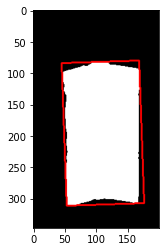

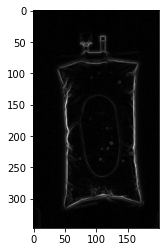

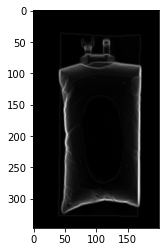

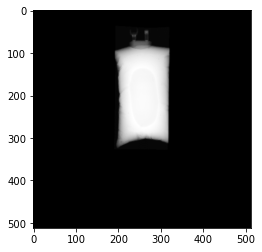

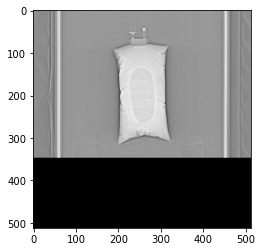

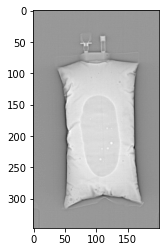

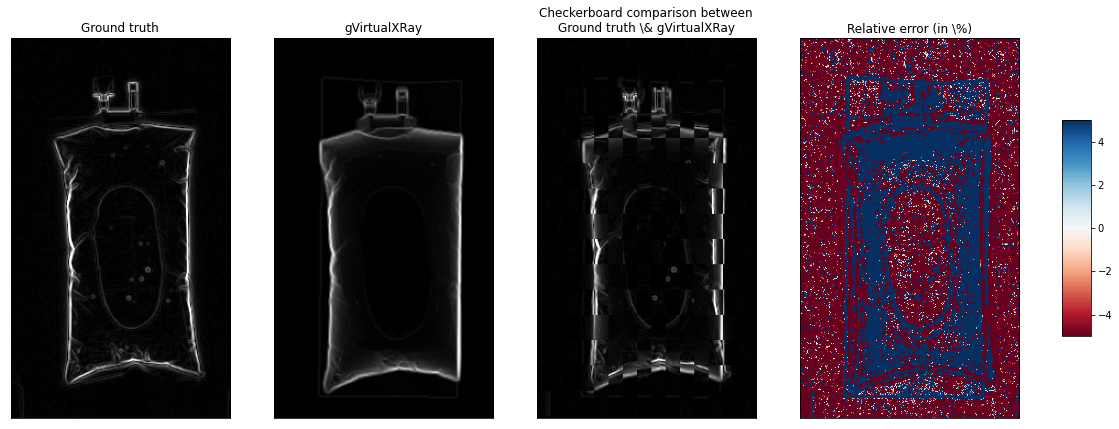

In [52]:
img = 255 * proj_array

img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
rect = cv.minAreaRect(contours[largest_contour])
box = cv.boxPoints(rect)
ref_box = np.int0(box)
cv.drawContours(img, [ref_box], 0, (255,0,0), 2)

plt.figure()
plt.imshow(img)

simulated_image = computeXRayImage([x, z, theta, pixel_size])
roi_simulated_image = simulated_image[:347,150:350]
test_sobel = standardisation(sitk.GetArrayFromImage(sitk.SobelEdgeDetection(sitk.GetImageFromArray(roi_simulated_image))))


plt.figure()
plt.imshow(ref_sobel, cmap="gray")

plt.figure()
plt.imshow(test_sobel, cmap="gray")

plt.figure()
plt.imshow(simulated_image, cmap="gray")

plt.figure()
plt.imshow(raw_real_image, cmap="gray",            vmin=-101, vmax = -7)

plt.figure()
plt.imshow(roi_raw_real_image, cmap="gray", 
           vmin=-101, vmax = -7)

fullCompareImages(ref_sobel,
                  test_sobel,
                  "gVirtualXRay",
                  "plots/saline_bag_full_comparison_sobel", vmin=test_sobel.min(), vmax=test_sobel.max())
# plt.figure(roi_simulated_image)
# plt.imshow(xray_image, cmap="gray")



In [53]:








# img = 255 * proj_array[0]

# img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
# rect = cv.minAreaRect(contours[largest_contour])
# box = cv.boxPoints(rect)
# ref_box = np.int0(box)
# cv.drawContours(img, [ref_box], 0, (255,0,0), 2)

# plt.imshow(img)

print(box)
print(box_index)
print(box[box_index])
print(objective)

gvxr.displayScene()

simulated_image = sitk.GetImageFromArray(roi_simulated_image)
sitk.WriteImage(simulated_image, "saline_bag/simulated_image.mha", useCompression=True)    

min_image = roi_simulated_image.min()
max_image = roi_simulated_image.max()
x_ray_image_uint8 = 255 * (roi_simulated_image - min_image) / (max_image - min_image)
imsave("saline_bag/simulated_image.tif", np.array(x_ray_image_uint8).astype(np.uint8))

[[ 45.18724   84.778465]
 [168.4912    80.46282 ]
 [176.42476  307.13516 ]
 [ 53.120804 311.4508  ]]
[0 3 1 2]
[[ 45.18724   84.778465]
 [ 53.120804 311.4508  ]
 [168.4912    80.46282 ]
 [176.42476  307.13516 ]]
0.0


In [54]:
roi_raw_real_image_blur = cv.GaussianBlur(roi_raw_real_image, (5, 5), 0)
x_ray_image_blur = cv.GaussianBlur(roi_simulated_image, (5, 5), 0)

In [55]:
def objectiveFunction(parameters):
    
    global roi_raw_real_image_blur
    global x_ray_image_blur
    global best_fitness
    global best_fitness_id
    global fitness_function_call_id   
    
    temp_image = ((x_ray_image_blur + parameters[0]) * parameters[1] + parameters[2]) * parameters[3]
    # Return the objective
    # objective = math.sqrt(mean_squared_error(np.diagonal(roi_raw_real_image), np.diagonal(temp_image)))
    # objective = mape(np.diagonal(roi_raw_real_image), np.diagonal(temp_image))
    # objective = np.abs(np.diagonal(roi_raw_real_image) - np.diagonal(temp_image)).sum()
    objective = mape(roi_raw_real_image_blur, temp_image)
    
    if best_fitness > objective:
        best_fitness = objective
        # print(objective, parameters)
        
    return objective

In [56]:
# The registration has already been performed. Load the results.
if False: #path.isfile("gVirtualXRay_output_data/saline_bag2.dat"):

    shift1, scale1, shift2, scale2 = np.loadtxt("gVirtualXRay_output_data/saline_bag2.dat")
    
# Optimise
else:
    
    # Initialise the values
    x0 = [0, 1, 0, 1]

    pixel_range = abs(roi_raw_real_image.max() - roi_raw_real_image.min())
    
    bounds = [
        [-pixel_range * 15, -pixel_range * 15, -pixel_range * 15, -pixel_range * 15],
        [ pixel_range * 15,  pixel_range * 15,  pixel_range * 15,  pixel_range * 15]
    ];

    print(bounds)
    
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-15);
    opts['tolx'] = 1e-15;
    opts['bounds'] = bounds;
    opts['CMA_stds'] = []
    
    best_fitness = sys.float_info.max;

    for min_val, max_val in zip(bounds[0], bounds[1]):
        opts['CMA_stds'].append((max_val - min_val) * 0.5)

    res = cma.fmin(objectiveFunction,
        x0,
        0.5,
        opts,
        restarts=1)

    # Save the parameters
    shift1, scale1, shift2, scale2 = res[0]

    np.savetxt("gVirtualXRay_output_data/saline_bag2.dat", res[0], header='shift1, scale1, shift2, scale2')

[[-1410, -1410, -1410, -1410], [1410, 1410, 1410, 1410]]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1125427, Wed Dec  8 14:30:18 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 7.083429614994438e+04 1.0e+00 4.25e-01  5e+02  6e+02 0:00.0
    2     16 1.247590667812405e+05 1.3e+00 3.70e-01  5e+02  5e+02 0:00.0
    3     24 1.545632689320515e+04 1.4e+00 3.25e-01  4e+02  4e+02 0:00.0
  100    800 3.744232927797904e-01 1.0e+02 6.09e-03  3e-01  7e+00 0:00.4
  200   1600 3.491002114472092e-01 5.4e+03 4.70e-02  4e-02  1e+02 0:00.8
  300   2400 1.562870341811102e-01 3.5e+03 2.74e-01  7e-02  5e+00 0:01.2
  400   3200 7.281047499245427e-02 2.4e+00 1.97e-03  1e-03  2e-03 0:01.6


/home/fpvidal/miniconda3/envs/gvxr-validation/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=392)
  warnings.warn(msg + ' (' +


  500   4000 7.281047333754788e-02 6.4e+02 2.63e-05  3e-06  1e-05 0:02.0
  507   4056 7.281047333779701e-02 6.7e+02 2.57e-05  3e-06  1e-05 0:02.0
termination on tolfunhist=1e-12 (Wed Dec  8 14:30:20 2021)
final/bestever f-value = 7.281047e-02 7.281047e-02
incumbent solution: [-10.291881801907039, -134.67565793610993, -1385.7333694664233, -23.216932517505484]
std deviation: [4.0023489759829335e-06, 9.942265329196789e-06, 5.552971093349614e-06, 2.616751292382245e-06]
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=1125428, Wed Dec  8 14:30:20 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1   4073 4.638795411440467e+03 1.0e+00 4.68e-01  6e+02  7e+02 0:00.0
    2   4089 8.310075662867613e+04 1.3e+00 4.91e-01  5e+02  8e+02 0:00.0
    3   4105 8.466968902552029e+03 1.7e+00 4.33e-01  4e+02  7e+02 0:00.0
  100   5657 3.741123524910981e-01 3.3e+04 3.30e-02  1e-02  4e+01 0:00.7
NOTE (module=cma, iteration=139):  
condition in coordinate system exceede

/home/fpvidal/miniconda3/envs/gvxr-validation/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=626)
  warnings.warn(msg + ' (' +


  700  15257 7.281047334978197e-02 6.0e+00 2.60e+04  8e+03  2e+04 0:05.1
  800  16857 7.281047333848616e-02 8.2e+01 1.88e+03  2e+02  3e+02 0:05.9
  900  18457 7.281047333891631e-02 1.9e+03 1.43e+04  1e+03  2e+03 0:06.6
termination on tolstagnation=200 after 1 restart (Wed Dec  8 14:30:28 2021)
final/bestever f-value = 7.281047e-02 7.281047e-02
incumbent solution: [1.316596586839296, -1066.4179433584213, 1406.6757595652368, -2.932017183979042]
std deviation: [2324.7063037362745, 1148.9858982836186, 1244.9121710295196, 2380.732914693799]


In [57]:
simulated_image = ((roi_simulated_image + shift1) * scale1 + shift2) * scale2
simulated_image_blur = ((x_ray_image_blur + shift1) * scale1 + shift2) * scale2

imsave("saline_bag/simulated_image.tif", np.array(simulated_image).astype(np.single))

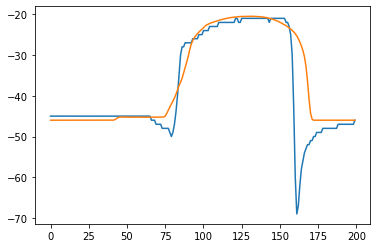

In [58]:
plt.figure()
plt.plot(np.diagonal(roi_raw_real_image_blur))
plt.plot(np.diagonal(simulated_image_blur))

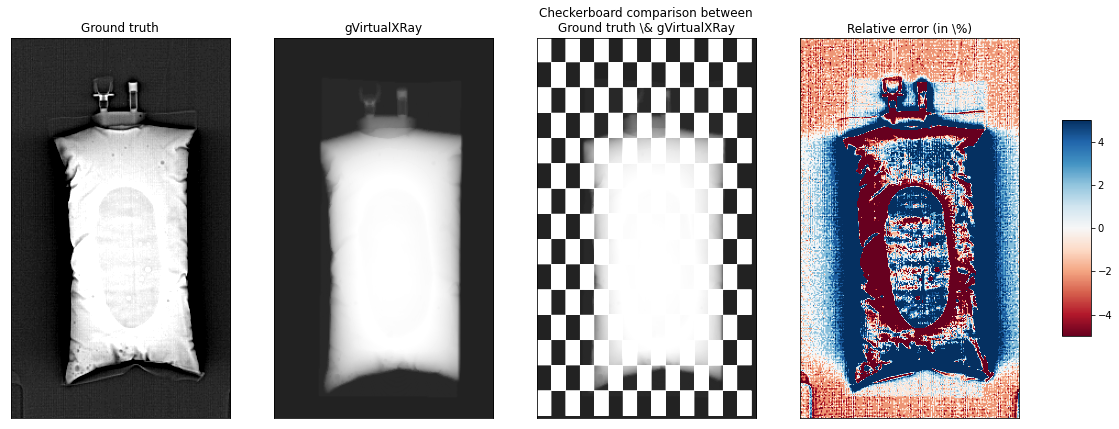

In [59]:
temp_ref = (roi_raw_real_image - roi_raw_real_image.min()) / (roi_raw_real_image.max() - roi_raw_real_image.min())
temp_sim = (simulated_image - roi_raw_real_image.min()) / (roi_raw_real_image.max() - roi_raw_real_image.min())

fullCompareImages(roi_raw_real_image,
                  simulated_image,
                  "gVirtualXRay",
                  "plots/saline_bag_full_comparison", vmin=-50, vmax = -20)

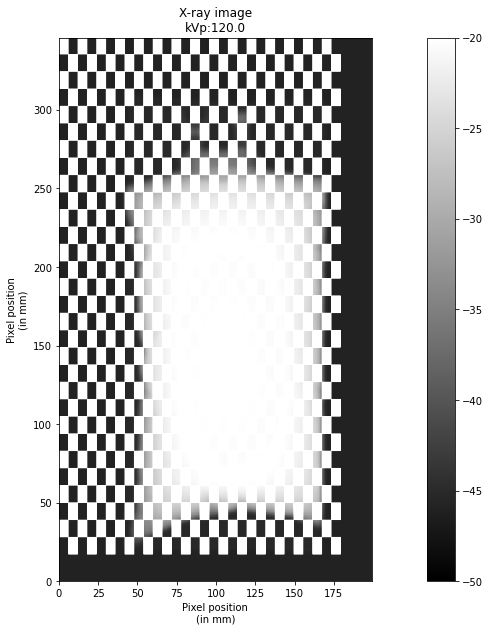

In [60]:
plt.figure(figsize= (20,10))

from skimage.util import compare_images # Checkboard comparison between two images

comp_equalized = compare_images(roi_raw_real_image_blur, simulated_image_blur, method='checkerboard', n_tiles=(30,30))

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title("X-ray image\nkVp:" + str(kVp))
plt.imshow(comp_equalized, cmap="gray", 
           vmin=-50, vmax = -20,
           extent=[0,(comp_equalized.shape[1]-1)*spacing[0],0,(comp_equalized.shape[0]-1)*spacing[1]],
           # norm=LogNorm(vmin=0.1, vmax=10)
          )

plt.colorbar(orientation='vertical')

plt.savefig('plots/saline_bag_simulated_image.pdf')
plt.savefig('plots/saline_bag_simulated_image.png')

In [61]:
gvxr.displayScene()